# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

c:\Users\usuario\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

c:\Users\usuario\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Data Structure

In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [6]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [7]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


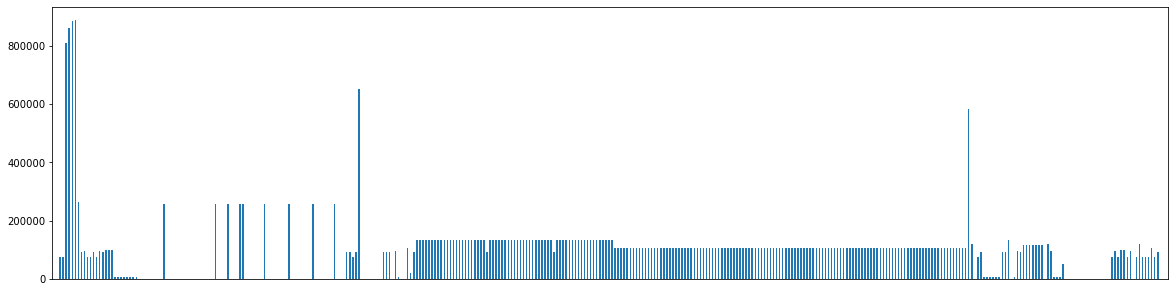

In [4]:
missing_values = azdias.isnull().sum()
missing_values.plot(kind='bar', figsize=(20,5))
plt.xticks([])
plt.show()

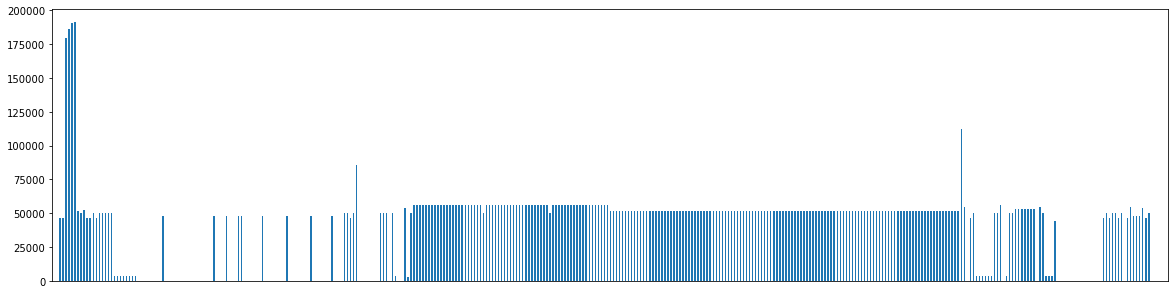

In [5]:
missing_values = customers.isnull().sum()
missing_values.plot(kind='bar', figsize=(20,5))
plt.xticks([])
plt.show()

### Data Cleaning

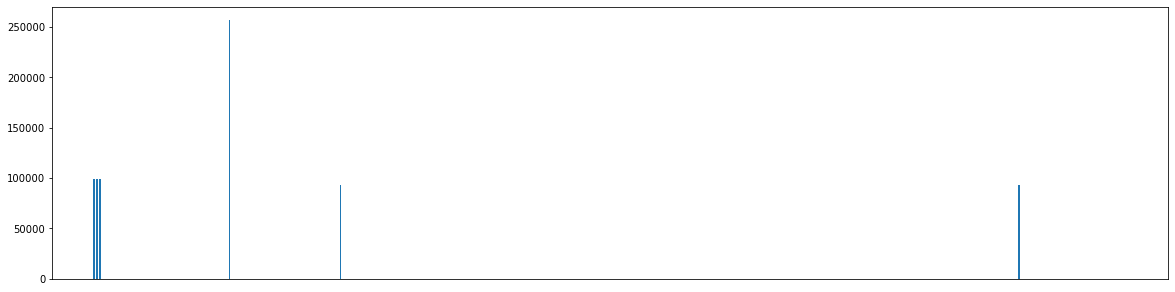

In [6]:
missing_percentage = azdias.isnull().sum() / len(azdias) * 100
for column, percentage in missing_percentage.iteritems():
    if percentage < 80:
        if azdias[column].dtype in ['int64', 'float64']:
            mean_value = azdias[column].mean()
            azdias[column].fillna(mean_value, inplace=True)
    else:
        azdias.drop(columns=[column], inplace=True)

missing_values = azdias.isnull().sum()
missing_values.plot(kind='bar', figsize=(20,5))
plt.xticks([])
plt.show()

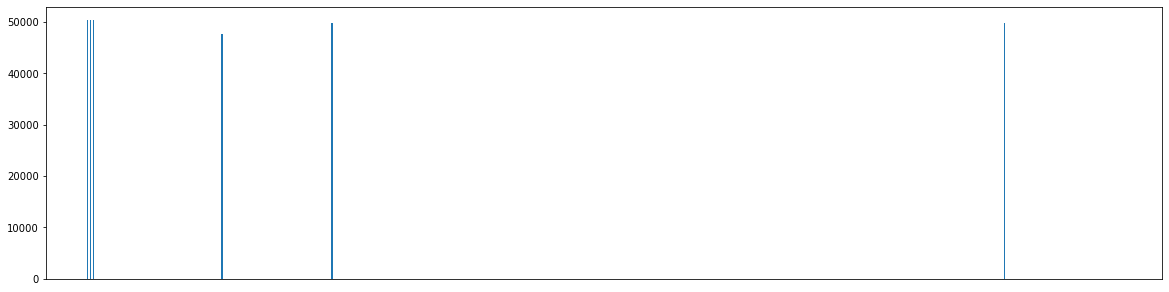

In [7]:
missing_percentage = customers.isnull().sum() / len(customers) * 100
for column, percentage in missing_percentage.iteritems():
    if percentage < 80:
        if customers[column].dtype in ['int64', 'float64']:
            mean_value = customers[column].mean()
            customers[column].fillna(mean_value, inplace=True)
    else:
        customers.drop(columns=[column], inplace=True)

missing_values = customers.isnull().sum()
missing_values.plot(kind='bar', figsize=(20,5))
plt.xticks([])
plt.show()

### Preprocessing
1. Descriptical analysis

In [8]:
correlation_matrix = azdias.corr()
drop_cols = [col for col in correlation_matrix.columns if any(correlation_matrix[col].abs() > 0.8)]
new_azdias= azdias.drop(columns=drop_cols, inplace=False)

In [9]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 362 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(263), int64(93), object(6)
memory usage: 2.4+ GB


In [10]:
new_azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 6 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   CAMEO_DEU_2015            792242 non-null  object
 1   CAMEO_DEUG_2015           792242 non-null  object
 2   CAMEO_INTL_2015           792242 non-null  object
 3   D19_LETZTER_KAUF_BRANCHE  634108 non-null  object
 4   EINGEFUEGT_AM             798073 non-null  object
 5   OST_WEST_KZ               798073 non-null  object
dtypes: object(6)
memory usage: 40.8+ MB


362 columns to 6.

In [11]:
correlation_matrix = customers.corr()
drop_cols = [col for col in correlation_matrix.columns if any(correlation_matrix[col].abs() > 0.8)]
new_customers = customers.drop(columns=drop_cols, inplace=False)

In [12]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 365 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(263), int64(94), object(8)
memory usage: 533.7+ MB


In [13]:
new_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   CAMEO_DEU_2015            141224 non-null  object
 1   CAMEO_DEUG_2015           141224 non-null  object
 2   CAMEO_INTL_2015           141224 non-null  object
 3   D19_LETZTER_KAUF_BRANCHE  143955 non-null  object
 4   EINGEFUEGT_AM             141725 non-null  object
 5   OST_WEST_KZ               141725 non-null  object
 6   PRODUCT_GROUP             191652 non-null  object
 7   CUSTOMER_GROUP            191652 non-null  object
dtypes: object(8)
memory usage: 11.7+ MB


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [26]:
new_azdias.head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,Cluster
0,NaN,NaN,NaN,NaN,NaN,NaN,2
1,8A,8.0,51.0,NaN,1992-02-10 00:00:00,W,2
2,4C,4.0,24.0,D19_UNBEKANNT,1992-02-12 00:00:00,W,2
3,2A,2.0,12.0,D19_UNBEKANNT,1997-04-21 00:00:00,W,4
4,6B,6.0,43.0,D19_SCHUHE,1992-02-12 00:00:00,W,1


In [25]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select the columns with categorical variables for one-hot encoding
categorical_columns = ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ']

# Perform one-hot encoding on the selected columns
new_azdias_encoded = pd.get_dummies(new_azdias, columns=categorical_columns, drop_first=True)

# Drop the 'EINGEFUEGT_AM' column
new_azdias_encoded.drop('EINGEFUEGT_AM', axis=1, inplace=True)

# Extract the selected features from your preprocessed data
X = new_azdias_encoded

# Standardize the features to have mean=0 and variance=1
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Choose the number of clusters (you can modify this)
n_clusters = 5

# Initialize the K-Means model
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Fit the model to the data
kmeans.fit(X_std)

# Get cluster assignments for each data point
cluster_labels = kmeans.labels_

# Add the cluster labels to your data
new_azdias['Cluster'] = cluster_labels

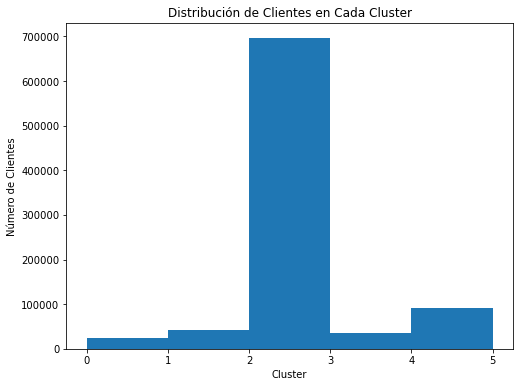

In [29]:
plt.figure(figsize=(8, 6))
plt.hist(cluster_labels, bins=range(n_clusters + 1))
plt.xlabel('Cluster')
plt.ylabel('Número de Clientes')
plt.title('Distribución de Clientes en Cada Cluster')
plt.show()


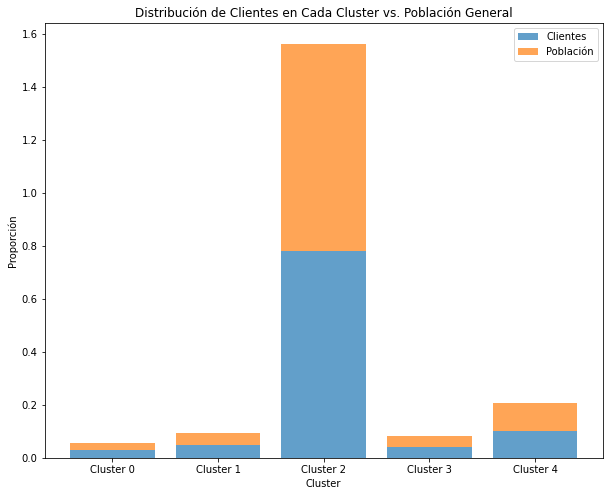

In [33]:
# Calcular la distribución de la población general en cada cluster
population_cluster_counts = []
for cluster in range(n_clusters):
    cluster_count = len(new_azdias[cluster_labels == cluster])
    population_cluster_counts.append(cluster_count)

# Crear una lista de etiquetas para los clusters
cluster_labels = [f'Cluster {cluster}' for cluster in range(n_clusters)]

# Número total de clientes y población
total_customers = len(new_azdias)
total_population = len(azdias)

# Calcular la proporción de clientes y población en cada cluster
customer_proportions = [count / total_customers for count in population_cluster_counts]
population_proportions = [count / total_population for count in population_cluster_counts]

# Crear un gráfico de barras apiladas
plt.figure(figsize=(10, 8))
plt.bar(cluster_labels, customer_proportions, label='Clientes', alpha=0.7)
plt.bar(cluster_labels, population_proportions, label='Población', alpha=0.7, bottom=customer_proportions)
plt.xlabel('Cluster')
plt.ylabel('Proporción')
plt.title('Distribución de Clientes en Cada Cluster vs. Población General')
plt.legend()
plt.show()


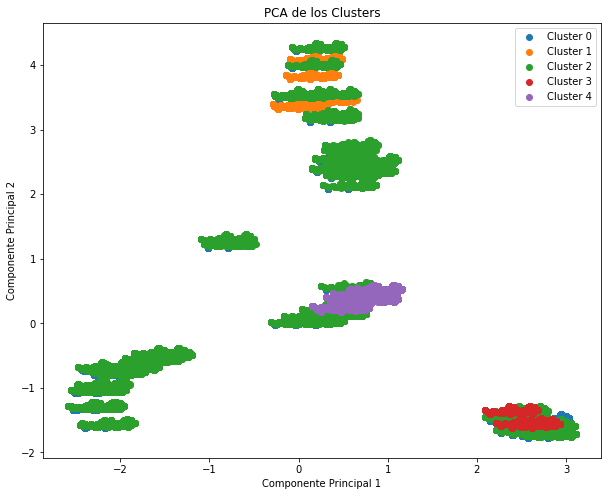

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    plt.scatter(X_pca[cluster_labels == cluster, 0], X_pca[cluster_labels == cluster, 1], label=f'Cluster {cluster}')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA de los Clusters')
plt.legend()
plt.show()


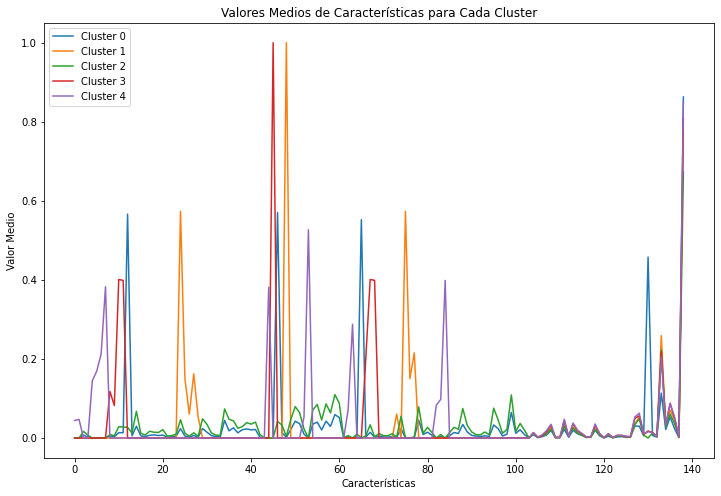

In [32]:
centroid_values = scaler.inverse_transform(kmeans.cluster_centers_)

plt.figure(figsize=(12, 8))
for cluster in range(n_clusters):
    plt.plot(centroid_values[cluster], label=f'Cluster {cluster}')
plt.xlabel('Características')
plt.ylabel('Valor Medio')
plt.title('Valores Medios de Características para Cada Cluster')
plt.legend()
plt.show()



## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [33]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

c:\Users\usuario\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [27]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [4]:
mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

c:\Users\usuario\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='RESPONSE', ylabel='count'>

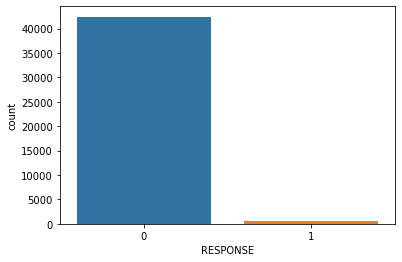

In [5]:
sns.countplot("RESPONSE", data=mailout_train)

In [34]:
non_numeric_columns = mailout_train.select_dtypes(exclude=['int64', 'float64']).columns
mailout_train.drop(columns=non_numeric_columns, inplace=True)
mailout_train.shape

(42962, 361)

In [35]:
column_means = mailout_train.mean()
mailout_train = mailout_train.fillna(column_means)
labels = mailout_train["RESPONSE"]

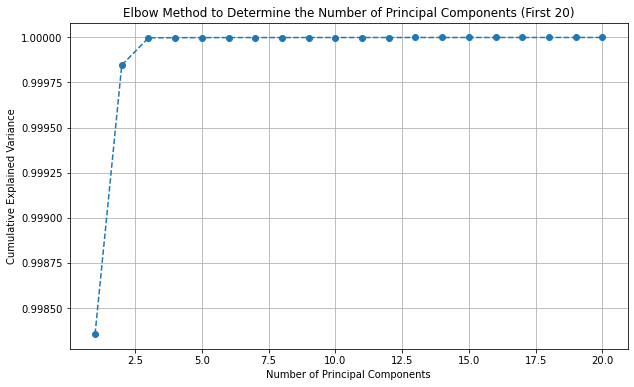

In [36]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA instance without specifying the number of components
pca = PCA()

# Fit PCA to the data
pca.fit(mailout_train)

# Get cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), cumulative_explained_variance[:20], marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Method to Determine the Number of Principal Components (First 20)')
plt.grid(True)
plt.show()

In [37]:
pca = PCA(n_components=3)
mailout_train = pca.fit_transform(mailout_train)

In [38]:
from sklearn.model_selection import train_test_split, cross_val_score


X_train, X_val, y_train, y_val = train_test_split(mailout_train, labels, stratify=labels, test_size=0.2)

In [39]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
    """
    Fit a model and returns AUROC score   
    """
    model = model.fit(X_train, y_train)
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    return roc

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix


models = [("LogisticRegression", LogisticRegression()),
         ("DecisionTreeClassifier", DecisionTreeClassifier()),
         ("RandomForestClassifier", RandomForestClassifier()),
         ("GradientBoostingClassifier", GradientBoostingClassifier()),
         ("AdaBoostClassifier", AdaBoostClassifier())]

results = {"Model":[],
          "AUCROC_score":[],
          }

for name, model in models:
    roc = train_and_predict(model, X_train, y_train, X_val, y_val)
    results["Model"].append(name)
    results["AUCROC_score"].append(roc)

results = pd.DataFrame.from_dict(results, orient='index').transpose()
results

,Model,AUCROC_score
0,LogisticRegression,0.50841
1,DecisionTreeClassifier,0.49859
2,RandomForestClassifier,0.49368
3,GradientBoostingClassifier,0.542874
4,AdaBoostClassifier,0.529989


GradientBoostingClassifier	0.542874